In [ ]:
%pip install z3-solver==4.12.4 # not working well with 4.15

In [18]:
import numpy as np
import textwrap
import time
from functools import partial
from itertools import chain, combinations, product
from sympy import fibonacci, primerange
from z3 import (
    And,
    Distinct,
    Exists,
    Goal,
    If,
    Implies,
    Int,
    IntVector,
    Not,
    Optimize,
    Or,
    Solver,
    Sum,
    Tactic,
    ToInt,
    get_full_version,
    sat,
    set_param,
)

In [4]:
from IPython.display import Image, display

url = "https://www.janestreet.com/puzzles/may-2025-update.png"
display(Image(url=url, width=800))

In [49]:
# pyplot stuff
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


def draw_grid(
    rows,
    cols,
    ax,
    *,
    grid,
    grid_groups,
    grid_highlights,
    grid_tiles=None,
    grid_deltas=None,
    labels=[],
):
    grid = np.array(grid)
    if grid_tiles is None:
        grid_tiles = np.ones((rows, cols), dtype=int)
    if grid_deltas is None:
        grid_deltas = np.zeros((rows, cols), dtype=int)

    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_aspect("equal")
    ax.axis("off")
    # base grid
    for r in range(rows):
        for c in range(cols):
            x, y = c, rows - 1 - r
            is_tiled = grid_tiles[r][c] == 0
            ax.add_patch(
                Rectangle(
                    (x, y),
                    1,
                    1,
                    facecolor="black" if is_tiled else "white",
                    edgecolor="black",
                    linewidth=1,
                )
            )
    # highlights
    for r in range(rows):
        for c in range(cols):
            if grid_highlights[r, c]:
                ax.add_patch(
                    Rectangle(
                        (c, rows - 1 - r),
                        1,
                        1,
                        facecolor="yellow",
                        edgecolor="black",
                        linewidth=1,
                    )
                )
    # regions
    for r in range(rows):
        for c in range(cols):
            x, y = c, rows - 1 - r
            if r == 0 or grid_groups[r, c] != grid_groups[r - 1, c]:
                ax.plot([x, x + 1], [y + 1, y + 1], color="black", linewidth=3)
            if r == rows - 1 or grid_groups[r, c] != grid_groups[r + 1, c]:
                ax.plot([x, x + 1], [y, y], color="black", linewidth=3)
            if c == 0 or grid_groups[r, c] != grid_groups[r, c - 1]:
                ax.plot([x, x], [y, y + 1], color="black", linewidth=3)
            if c == cols - 1 or grid_groups[r, c] != grid_groups[r, c + 1]:
                ax.plot([x + 1, x + 1], [y, y + 1], color="black", linewidth=3)
    # frame
    ax.plot(
        [0, cols, cols, 0, 0],
        [0, 0, rows, rows, 0],
        color="black",
        linewidth=6,
    )
    # digits
    for r in range(rows):
        for c in range(cols):
            val = int(grid[r, c])
            if val != 0:
                ax.text(
                    c + 0.5,
                    rows - 1 - r + 0.5,
                    str(val),
                    color="red" if grid_deltas[r][c] != 0 else "black",
                    ha="center",
                    va="center",
                    fontsize=26,
                )
    # labels
    for i, text in enumerate(labels):
        ax.text(
            -0.3,
            rows - 0.5 - i,
            text,
            ha="right",
            va="center",
            fontsize=16,
        )


def draw_footer(ax, nums, total):
    props = {
        "ha": "center",
        "va": "top",
        "transform": ax.transAxes,
        "fontweight": 600,
        "fontsize": 10,
    }
    ax.text(
        0.5,
        -0.02,
        "Answer:",
        **props,
    )
    ax.text(
        0.5,
        -0.10,
        "\n".join(
            textwrap.wrap(" + ".join(map(str, nums)), width=80),
        ),
        **props,
    )
    text = ax.text(
        0.45,
        -0.18,
        "= ",
        **props,
    )
    text = ax.annotate(
        total,
        xycoords=text,
        xy=(1, 0),
        verticalalignment="bottom",
        color="red",
        fontsize=12,
        fontweight=600,
    )

In [44]:
class CrossNumbersSolver:
    DIRECTIONS = [(0, -1), (-1, 0), (0, 1), (1, 0)]

    def __init__(self, grid, grid_groups, grid_highlights, clues, tactic="default", labels=[]):
        self.solver = Tactic(tactic).solver()
        self.grid_highlights = grid_highlights
        self.rows = grid.shape[0]
        self.cols = grid.shape[1]
        self.clues = clues
        self.labels = labels
        self.grid_groups = grid_groups
        self.empty_grid = np.zeros((self.rows, self.cols), dtype=object)

        r, c = self.rows, self.cols
        size = self.rows * self.cols
        self.grid_tiles = np.array(IntVector("t", size), dtype=object).reshape(r, c)
        self.grid = np.array(IntVector("x", size), dtype=object).reshape(r, c)
        self.grid_deltas = np.empty((r, c, 4), dtype=object)

        for i in range(r):
            for j in range(c):
                if self.is_highlighed_cell(i, j):
                    continue
                for _, nr, nc, dr, dc in self.walk_neighbors(i, j):
                    if self.is_highlighed_cell(nr, nc):
                        continue
                    if nc == 1 or nc == self.cols - 2:
                        continue
                    index = self.direction_to_index(dr, dc)
                    self.grid_deltas[i][j][index] = Int("deltas{}_{}_{}".format(nr, nc, index))

        self.group_ids = np.unique(grid_groups)
        self.groups = [(grid_groups == gid).astype(int) for gid in self.group_ids]
        self.group_ints = [Int("group_{}".format(id)) for id in self.group_ids]

    def direction_to_index(self, dir_row, dir_col):
        match [dir_row, dir_col]:
            case [0, -1]:
                return 0
            case [-1, 0]:
                return 1
            case [0, 1]:
                return 2
            case [1, 0]:
                return 3

    def direction_to_index_inverted(self, dir_row, dir_col):
        match [dir_row, dir_col]:
            case [0, -1]:
                return 2
            case [-1, 0]:
                return 3
            case [0, 1]:
                return 0
            case [1, 0]:
                return 1

    def eval_grid(self, model, grid):
        res = np.ones((self.rows, self.cols), dtype=int)
        for row_index, row in enumerate(grid):
            for col_index, col in enumerate(row):
                if isinstance(col, np.ndarray):
                    res[row_index][col_index] = sum(
                        [model.eval(x).as_long() for x in col if x is not None]
                    )
                else:
                    res[row_index][col_index] = model.eval(col).as_long()
        return res

    def merge_grids(self, grid, grid_delta, grid_tiles):
        grid = np.array(grid)
        grid_delta = np.array(grid_delta)
        grid_tiles = np.array(grid_tiles)
        merged = grid + grid_delta
        merged[grid == 0] = 0
        merged[grid_tiles == 0] = 0
        return merged

    def sum_total(self, grid):
        total = 0
        nums = []
        for row in grid:
            num = 0
            total_row = 0
            for digit in row:
                if digit != 0:
                    num = num * 10 + digit
                else:
                    if num > 0:
                        nums.append(int(num))
                    total_row += num
                    num = 0
            if num > 0:
                total_row += num
                nums.append(int(num))
            total += total_row
        return total, nums

    def generate_fibonacci(self):
        res = []
        for i in range(1, 60):
            fib = fibonacci(i)
            length = len(str(fib))
            if len(res) == length:
                res[length - 1].append(fib)
            else:
                res.append([fib])
        return res

    def generate_primes(self, max_digits):
        result = [[] for _ in range(max_digits)]
        for n_digits in range(1, max_digits + 1):
            for p in primerange(10 ** (n_digits - 1), 10**n_digits):
                if "0" not in str(p):
                    result[n_digits - 1].append(p)
        return result

    def walk_group(self, index: int):
        group = self.groups[index]
        for row, col in np.argwhere(group == 1):
            yield self.grid[row][col], row, col

    def walk_neighbors(self, row, col, directions=DIRECTIONS):
        for dir_row, dir_col in directions:
            next_row = row + dir_row
            next_col = col + dir_col
            if (
                next_row >= 0
                and next_row <= (self.rows - 1)
                and next_col >= 0
                and next_col <= (self.cols - 1)
            ):
                yield (
                    self.grid_tiles[next_row][next_col],
                    next_row,
                    next_col,
                    dir_row,
                    dir_col,
                )

    def walk_digits(self, row_index, min=2):
        slices = ((l, r) for l, r in combinations(range(self.cols + 1), 2) if r > l + (min - 1))
        for l, r in slices:
            digits = []
            for i, d in enumerate(self.grid[row_index][l:r]):
                col_index = l + i
                sum_delta = self.get_sum_deltas(row_index, col_index)
                digits.append(d + sum_delta)
            yield digits, l, r

    def get_deltas(self, row, col):
        return [d for d in self.grid_deltas[row][col] if d is not None]

    def get_sum_deltas(self, row, col):
        return Sum(self.get_deltas(row, col))

    def is_highlighed_cell(self, row, col):
        return self.grid_highlights[row][col] == 1

    def is_digit_match(self, row_index, l, r):
        return And(
            l == 0 or self.grid_tiles[row_index][l - 1] == 0,
            r == self.cols or self.grid_tiles[row_index][r] == 0,
            And([b != 0 for b in self.grid_tiles[row_index][l:r]]),
        )

    def sum_digits(self, digits):
        return sum(10**i * digits[-1 - i] for i in range(len(digits)))

    def is_square_value(self, value):
        x = Int(f"sq_{value.hash()}")
        return And(x >= 0, value == x * x)

    def is_square(self, row_index: int):
        for digits, l, r in self.walk_digits(row_index):
            block = self.sum_digits(digits)
            self.solver.add(
                Implies(
                    self.is_digit_match(row_index, l, r),
                    And(
                        # Hack to removes duplicates, hardcoded for now
                        Implies(len(digits) == 3 and (l == 0 or l == 4), block != 225),
                        self.is_square_value(block),
                    ),
                    # ToInt(block**0.5) == block**0.5, # this crashes z3
                )
            )

    def is_product_of_20(self, row_index):
        for digits, l, r in self.walk_digits(row_index):
            count_2 = Sum([If(d == 2, 1, 0) for d in digits])
            count_4 = Sum([If(d == 4, 1, 0) for d in digits])
            count_5 = Sum([If(d == 5, 1, 0) for d in digits])
            self.solver.add(
                Implies(
                    self.is_digit_match(row_index, l, r),
                    And(
                        And([Or(d == 1, d == 2, d == 4, d == 5) for d in digits]),
                        count_5 == 1,
                        count_4 < 2,
                        Implies(count_4 == 1, count_2 == 0),
                        Implies(count_4 == 0, count_2 == 2),
                    ),
                ),
            )

    def is_product_of_25(self, row_index: int):
        for digits, l, r in self.walk_digits(row_index):
            self.solver.add(
                Implies(
                    self.is_digit_match(row_index, l, r),
                    And(
                        And([Or(d == 1, d == 5) for d in digits]),
                        Sum([If(d == 5, 1, 0) for d in digits]) == 2,
                    ),
                ),
            )

    def is_product_of_2025(self, row_index):
        self.solver.add(
            And(
                self.grid_tiles[row_index][2] == 1,
                self.grid_tiles[row_index][3] == 1,
                self.grid_tiles[row_index][self.cols - 3] == 1,
                self.grid_tiles[row_index][self.cols - 4] == 1,
            )
        )
        self.solver.add(
            Implies(
                self.grid_tiles[row_index][0] == 0,
                And(
                    self.grid_tiles[row_index][3] != 0,
                    self.grid_tiles[row_index][4] != 0,
                ),
            )
        )
        self.solver.add(
            Implies(
                self.grid_tiles[row_index][self.cols - 1] == 0,
                And(
                    self.grid_tiles[row_index][self.cols - 4] != 0,
                    self.grid_tiles[row_index][self.cols - 5] != 0,
                ),
            )
        )
        for digits, l, r in self.walk_digits(row_index, 4):
            block = self.sum_digits(digits)
            count_5 = Sum([If(d == 5, 1, 0) for d in digits])
            count_9 = Sum([If(d == 9, 1, 0) for d in digits])
            count_3 = Sum([If(d == 3, 1, 0) for d in digits])
            self.solver.add(
                Implies(
                    self.is_digit_match(row_index, l, r),
                    And(
                        block >= 5599,  # needed
                        And([Or(d == 1, d == 3, d == 5, d == 9) for d in digits]),
                        count_5 == 2,
                        Or(count_3 == 0, count_3 == 2, count_3 == 3, count_3 == 4),
                        Implies(count_3 >= 3, count_9 == 0),
                        Implies(count_9 == 1, count_3 >= 2),
                    ),
                ),
            )

    # only for example
    def is_multiple_of(self, value: int, row_index: int):
        for digits, l, r in self.walk_digits(row_index):
            block = self.sum_digits(digits)
            x = Int(f"mult_{row_index}_{block.hash()}_div_{value}")
            self.solver.add(
                Implies(
                    self.is_digit_match(row_index, l, r),
                    block == x * value,
                    # block % value == 0,
                )
            )

    def is_multiple_of_13(self, row_index: int):
        for digits, l, r in self.walk_digits(row_index):
            block = self.sum_digits(digits)
            x = Int(f"mult_{row_index}_{block.hash()}_13")
            self.solver.add(
                Implies(
                    self.is_digit_match(row_index, l, r),
                    # block == q * 13,
                    If(
                        len(digits) == 2,
                        Or(
                            block == 13,
                            block == 26,
                            block == 39,
                            block == 52,
                            block == 65,
                            block == 78,
                            block == 91,
                        ),
                        block == x * 13,
                    ),
                )
            )

    def is_multiple_of_32(self, row_index: int):
        for digits, l, r in self.walk_digits(row_index):
            block = self.sum_digits(digits)
            x = Int(f"mult_{row_index}_{block.hash()}_32")
            last_digit = digits[len(digits) - 1]
            self.solver.add(
                Implies(
                    self.is_digit_match(row_index, l, r),
                    And(
                        Or([last_digit == 2, last_digit == 4, last_digit == 6, last_digit == 8]),
                        block == x * 32,
                        # block % 32 == 0,
                    ),
                )
            )

    def is_divisible(self, row_index: int):
        for digits, l, r in self.walk_digits(row_index, 2):
            block = self.sum_digits(digits)
            cons = []
            for d in digits:
                x = Int("div_{}{}".format(row_index, d.hash()))
                cons.append(block == x * d)
            self.solver.add(
                Implies(
                    self.is_digit_match(row_index, l, r),
                    And(cons),
                    # And([(block % d) == 0 for d in digits]),
                )
            )

    def is_odd_palindrome(self, row_index: int):
        for digits, l, r in self.walk_digits(row_index):
            block = self.sum_digits(digits)
            self.solver.add(
                Implies(
                    self.is_digit_match(row_index, l, r),
                    And(
                        block % 2 != 0,
                        And([digits[i] == digits[-1 - i] for i in range(len(digits) // 2)]),
                    ),
                )
            )

    def is_fibonacci(self, row_index: int):
        fibs = self.generate_fibonacci()
        for digits, l, r in self.walk_digits(row_index):
            block = self.sum_digits(digits)
            self.solver.add(
                Implies(
                    self.is_digit_match(row_index, l, r),
                    Or([block == s for s in fibs[len(digits) - 1]]),
                )
            )

    def is_prime(self, row_index: int):
        n = 3
        primes = self.generate_primes(n)
        for digits, l, r in self.walk_digits(row_index):
            block = self.sum_digits(digits)
            if len(digits) <= n:
                self.solver.add(
                    Implies(
                        self.is_digit_match(row_index, l, r),
                        Or([block == x for x in primes[len(digits) - 1]]),
                    )
                )
            else:
                self.solver.add(
                    Implies(
                        self.is_digit_match(row_index, l, r),
                        Or(block % 10 == 1, block % 10 == 3, block % 10 == 7, block % 10 == 9),
                    )
                )

    def constrain_neighbors(self, cell, row, col):
        neighbors = []
        for neighbor, next_row, next_col, _, dir_col in self.walk_neighbors(row, col):
            neighbors.append(neighbor)
            if dir_col != 0:
                for n in self.walk_neighbors(next_row, next_col, directions=[[0, dir_col]]):
                    neighbors.append(n[0])
        self.solver.add(
            Implies(
                cell == 0,
                And([n != 0 for n in neighbors]),
            )
        )

    def walk_neighbors_delta_combinations(self, iterable):
        s = list(iterable)
        n = len(s)
        for r in range(1, n + 1):
            for subset in combinations(s, r):
                subset_set = set(subset)
                rest = [item for item in s if item not in subset_set]
                yield [s for s in subset if s is not None], rest

    def solve(self):
        print(f"Initialized solution for {self.rows} rows and {self.cols} cols")
        self.solver.add([And(g >= 1, g <= 9) for g in self.group_ints])

        for group_index, g in enumerate(self.groups):
            for cell, row, col in self.walk_group(group_index):
                deltas = self.get_deltas(row, col)
                sum_deltas = self.get_sum_deltas(row, col)
                tile = self.grid_tiles[row][col]
                self.constrain_neighbors(tile, row, col)

                self.solver.add(And(tile >= 0, tile <= 1), cell == self.group_ints[group_index])

                if self.is_highlighed_cell(row, col):
                    self.solver.add(tile == 1, sum_deltas == 0)
                else:
                    self.solver.add(
                        And([d >= 0 for d in deltas]),
                        sum_deltas < (10 - self.group_ints[group_index]),
                    )

                if col == 1 or col == self.cols - 2:
                    self.solver.add(tile == 1)

                neighbors = []
                neighbor_deltas = []
                for neighbor, nr, nc, dr, dc in self.walk_neighbors(row, col):
                    neighbors.append(neighbor)
                    delta_index = self.direction_to_index_inverted(dr, dc)
                    d = self.grid_deltas[nr][nc][delta_index]
                    if d is not None:
                        neighbor_deltas.append(d)

                neighbor_is_zero = Or([n == 0 for n in neighbors])
                self.solver.add(Implies(Not(neighbor_is_zero), sum_deltas == 0))

                possible_sums = []
                for increments, rest in self.walk_neighbors_delta_combinations(neighbor_deltas):
                    possible_sums.append(
                        And(
                            Sum(increments) == self.group_ints[group_index],  # force the increments
                            And([r == 0 for r in rest]),
                        )
                    )

                self.solver.add(
                    If(
                        tile == 0,
                        Or(possible_sums),
                        And([n == 0 for n in neighbor_deltas]),
                    ),
                )

        for row_index in range(self.rows):
            clue = self.clues[row_index]
            clue(row_index)

        print("checking...")
        if self.solver.check() == sat:
            model = self.solver.model()
            groups = [model.eval(g) for g in self.group_ints]
            grid = self.eval_grid(model, self.grid)
            grid_deltas = self.eval_grid(model, self.grid_deltas)
            grid_tiles = self.eval_grid(model, self.grid_tiles)
            grid_placements = self.eval_grid(model, self.grid)
            grid_final = self.merge_grids(grid, grid_deltas, grid_tiles)
            total, nums = self.sum_total(grid_final)
            print("Satisfied!")
            # print(self.solver.statistics())
            print("")
            print("Groups\n", groups)
            print("")
            print("Tiles\n", grid_tiles)
            print("")
            print("Increments\n", grid_deltas)
            print("")
            print("Initial Placements\n", grid_placements)
            print("")
            print("Final Grid\n", grid_final)
            print("")
            print("numbers:", nums)
            print("total:", total)
            rows, cols = self.rows, self.cols
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(cols, rows))
            fig.set_figwidth((cols * 2) + 3)
            fig.set_figheight(rows + 1)
            ax1.set_title("(after initial placement)", fontsize=14)
            title = ax2.set_title(
                "(after tiles placed; altered values in ",
                fontsize=14,
                loc="center",
            )
            title = ax2.annotate(
                "red",
                xycoords=title,
                xy=(1, 0),
                verticalalignment="bottom",
                color="red",
                fontsize=14,
            )
            title = ax2.annotate(
                ")",
                xycoords=title,
                xy=(1, 0),
                verticalalignment="bottom",
                color="black",
                fontsize=14,
            )
            draw_grid(
                rows,
                cols,
                ax1,
                grid=grid_placements,
                grid_groups=self.grid_groups,
                grid_highlights=self.grid_highlights,
                labels=self.labels,
            )
            draw_grid(
                rows,
                cols,
                ax2,
                grid=grid_final,
                grid_groups=self.grid_groups,
                grid_highlights=self.grid_highlights,
                grid_tiles=grid_tiles,
                grid_deltas=grid_deltas,
                labels=self.labels,
            )
            draw_footer(ax2, nums, total)
            plt.tight_layout(pad=2)
            plt.show()
        else:
            print("Not sat")
            print("conflict:", self.solver.unsat_core())
            print("reason:", self.solver.reason_unknown())

Initialized solution for 5 rows and 5 cols
checking...
Satisfied!

Groups
 [5, 2, 9]

Tiles
 [[1 1 0 1 1]
 [1 1 1 1 0]
 [1 1 0 1 1]
 [0 1 1 1 1]
 [1 1 1 1 1]]

Increments
 [[0 0 0 3 3]
 [0 0 2 1 0]
 [6 2 0 0 1]
 [0 3 3 0 0]
 [0 0 0 0 0]]

Initial Placements
 [[5 5 5 5 5]
 [2 5 5 5 5]
 [2 2 5 5 5]
 [9 2 2 5 5]
 [9 9 2 2 5]]

Final Grid
 [[5 5 0 8 8]
 [2 5 7 6 0]
 [8 4 0 5 6]
 [0 5 5 5 5]
 [9 9 2 2 5]]

numbers: [55, 88, 2576, 84, 56, 5555, 99225]
total: 107639


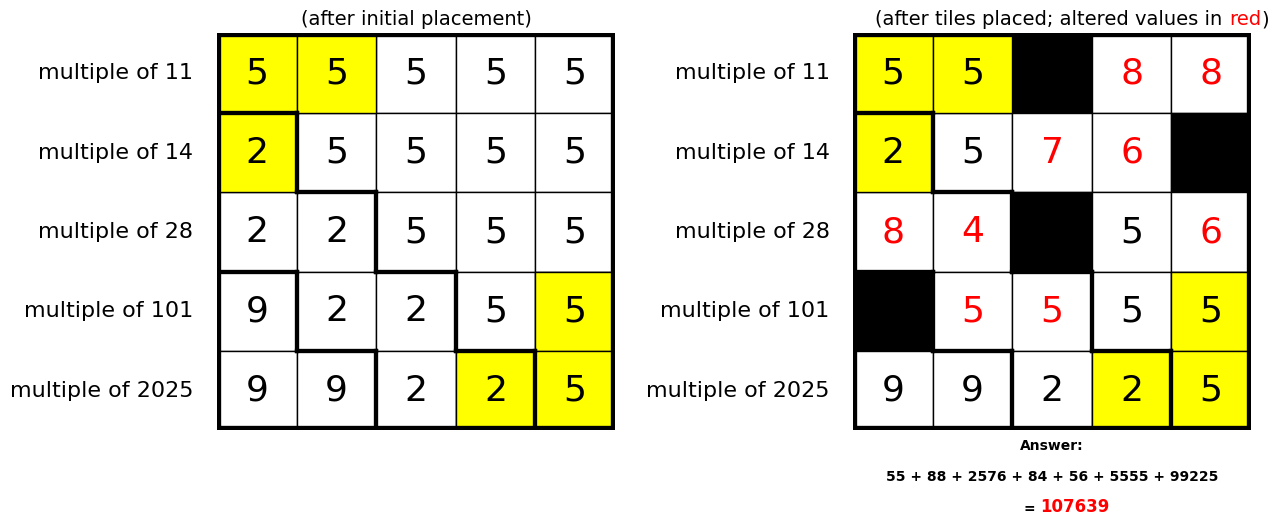


done in 0.19107985496520996


In [45]:
def solve_example():
    example_grid = np.ones((5, 5), dtype=int)
    example_groups = np.array(
        [
            [1, 1, 1, 1, 1],
            [2, 1, 1, 1, 1],
            [2, 2, 1, 1, 1],
            [3, 2, 2, 1, 1],
            [3, 3, 2, 2, 1],
        ]
    )
    example_highligths = np.array(
        [
            [1, 1, 0, 0, 0],
            [1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1],
            [0, 0, 0, 1, 1],
        ]
    )

    solver = CrossNumbersSolver(
        grid=example_grid,
        grid_groups=example_groups,
        grid_highlights=example_highligths,
        clues=[],
        tactic="default",
        labels=[
            "multiple of 11",
            "multiple of 14",
            "multiple of 28",
            "multiple of 101",
            "multiple of 2025",
        ],
    )
    solver.clues = [
        partial(solver.is_multiple_of, 11),
        partial(solver.is_multiple_of, 14),
        partial(solver.is_multiple_of, 28),
        partial(solver.is_multiple_of, 101),
        partial(solver.is_multiple_of, 2025),
    ]
    solver.solver.add(
        And(
            solver.group_ints[1] != solver.group_ints[0],
            solver.group_ints[1] != solver.group_ints[2],
        )
    )
    solver.solver.add(
        solver.group_ints[0] == 5,
        solver.group_ints[1] == 2,
        solver.group_ints[2] == 9,
    )
    solver.solve()


start = time.time()
solve_example()
end = time.time() - start
print("")
print(f"done in {end}")

Initialized solution for 11 rows and 11 cols
checking...
Satisfied!

Groups
 [2, 3, 4, 4, 1, 6, 3, 7, 7]

Tiles
 [[0 1 1 1 1 1 1 0 1 1 1]
 [1 1 0 1 1 1 0 1 1 1 0]
 [0 1 1 1 1 0 1 1 0 1 1]
 [1 1 1 0 1 1 0 1 1 1 0]
 [0 1 1 1 0 1 1 0 1 1 1]
 [1 1 0 1 1 1 0 1 1 1 0]
 [0 1 1 1 1 1 1 1 0 1 1]
 [1 1 1 0 1 1 1 0 1 1 0]
 [1 1 0 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 0 1 1 1 1 0]
 [0 1 1 0 1 1 1 0 1 1 1]]

Increments
 [[0 1 2 0 0 0 3 0 1 0 2]
 [3 0 0 0 0 3 0 0 3 0 0]
 [0 1 0 1 0 0 2 1 0 0 2]
 [3 0 3 0 0 1 0 1 0 0 0]
 [0 2 2 1 0 1 1 0 4 0 2]
 [1 1 0 1 1 0 0 0 4 4 0]
 [0 0 0 1 0 0 0 1 0 0 4]
 [3 0 1 0 3 0 3 0 3 2 0]
 [0 1 0 1 0 0 0 1 0 1 2]
 [2 0 2 6 0 0 2 6 6 2 0]
 [0 1 0 0 1 1 0 0 1 0 0]]

Initial Placements
 [[2 2 2 2 2 2 2 2 2 2 2]
 [2 4 2 2 2 2 2 2 2 2 2]
 [4 4 3 3 3 3 4 4 4 2 4]
 [4 3 3 4 3 1 4 4 4 4 4]
 [4 3 3 4 3 1 1 4 4 1 4]
 [4 4 4 4 4 1 1 1 1 1 4]
 [4 3 6 6 4 4 1 1 6 1 1]
 [4 3 6 6 6 6 6 6 6 7 7]
 [3 3 3 3 6 3 6 7 7 7 7]
 [3 3 3 3 3 3 3 3 3 3 3]
 [3 3 7 7 7 7 7 7 3 3 3]]

Final Grid
 [[0 3 4 2 2 

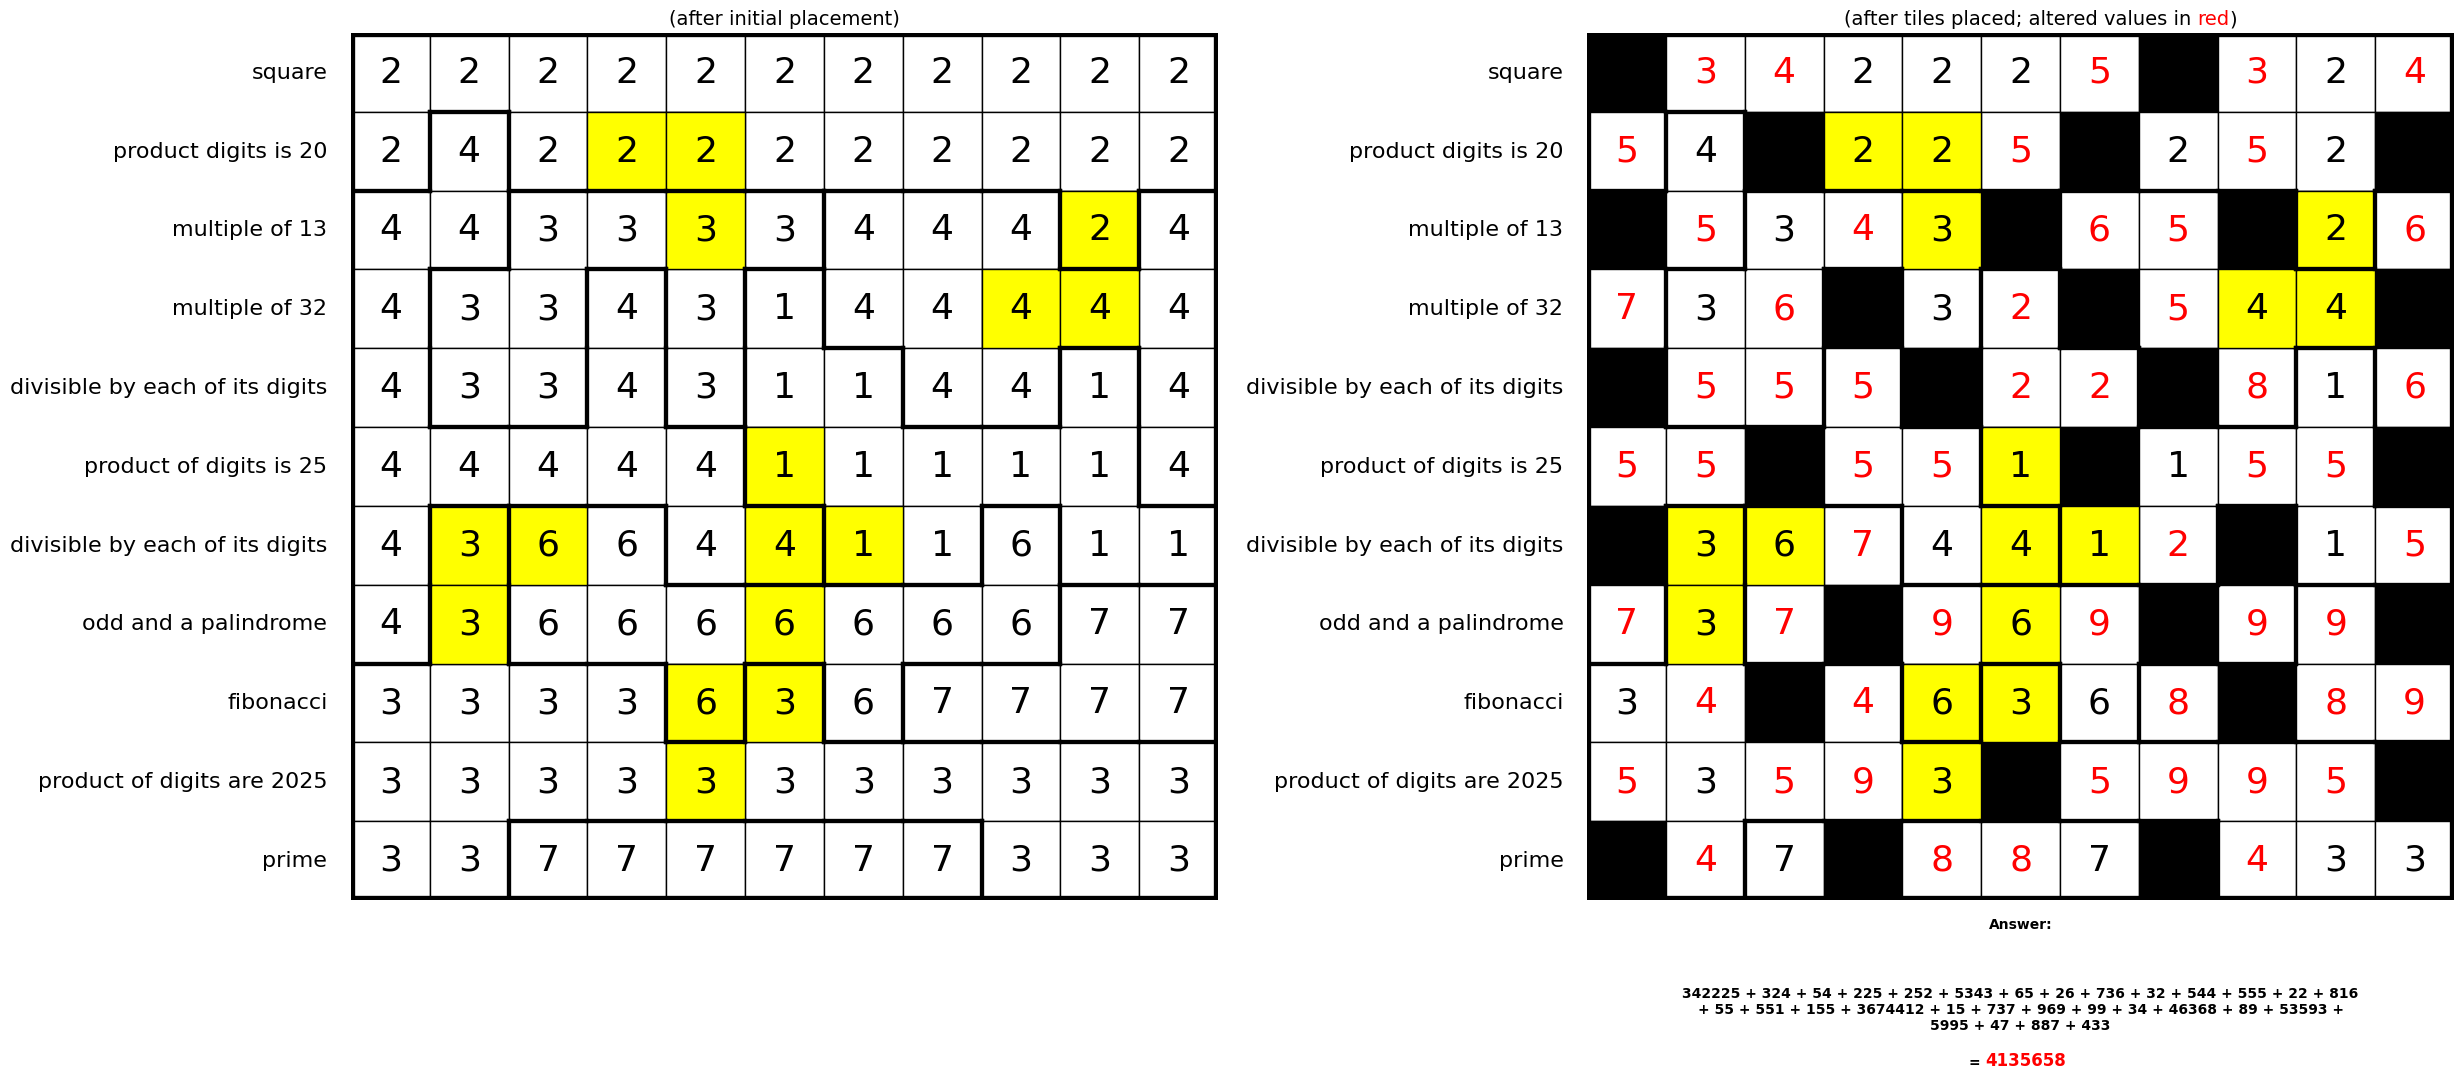


done in 33.158448934555054


In [50]:
def solve_main():
    grid_groups = np.array(
        [
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [3, 3, 2, 2, 2, 2, 4, 4, 4, 1, 4],
            [3, 2, 2, 3, 2, 5, 4, 4, 4, 4, 4],
            [3, 2, 2, 3, 2, 5, 5, 4, 4, 5, 4],
            [3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 4],
            [3, 7, 6, 6, 3, 3, 5, 5, 6, 5, 5],
            [3, 7, 6, 6, 6, 6, 6, 6, 6, 9, 9],
            [7, 7, 7, 7, 6, 7, 6, 9, 9, 9, 9],
            [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
            [7, 7, 8, 8, 8, 8, 8, 8, 7, 7, 7],
        ]
    )

    grid_highlights = np.array(
        [
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]
    )

    grid = np.ones((11, 11), dtype=int)

    solver = CrossNumbersSolver(
        grid=grid,
        grid_groups=grid_groups,
        grid_highlights=grid_highlights,
        clues=[],
        tactic="default",
        labels=[
            "square",
            "product digits is 20",
            "multiple of 13",
            "multiple of 32",
            "divisible by each of its digits",
            "product of digits is 25",
            "divisible by each of its digits",
            "odd and a palindrome",
            "fibonacci",
            "product of digits are 2025",
            "prime",
        ],
    )
    solver.clues = [
        solver.is_square,
        solver.is_product_of_20,
        solver.is_multiple_of_13,
        solver.is_multiple_of_32,
        solver.is_divisible,
        solver.is_product_of_25,
        solver.is_divisible,
        solver.is_odd_palindrome,
        solver.is_fibonacci,
        solver.is_product_of_2025,
        solver.is_prime,
    ]
    solver.solver.add(
        Or(
            solver.group_ints[0] == 1,
            solver.group_ints[0] == 2,
            solver.group_ints[0] == 4,
            solver.group_ints[0] == 5,
        ),
        Or(
            solver.group_ints[4] == 1,
            solver.group_ints[4] == 5,
        ),
        Or(
            solver.group_ints[6] == 1,
            solver.group_ints[6] == 3,
            solver.group_ints[6] == 5,
            solver.group_ints[6] == 9,
        ),
    )
    # group hints, (we are forcing the correct regions here, without this it takes a really long time)
    solver.solver.add(
        solver.group_ints[0] == 2,
        solver.group_ints[1] == 3,
        solver.group_ints[2] == 4,
        solver.group_ints[3] == 4,
        solver.group_ints[4] == 1,
        solver.group_ints[5] == 6,
        solver.group_ints[6] == 3,
        solver.group_ints[7] == 7,
        solver.group_ints[8] == 7,
    )
    solver.solver.add(
        solver.group_ints[0] != solver.group_ints[1],
        solver.group_ints[0] != solver.group_ints[2],
        solver.group_ints[0] != solver.group_ints[3],
        # region 2
        solver.group_ints[1] != solver.group_ints[0],
        solver.group_ints[1] != solver.group_ints[2],
        solver.group_ints[1] != solver.group_ints[3],
        solver.group_ints[1] != solver.group_ints[4],
        # region 3
        solver.group_ints[2] != solver.group_ints[0],
        solver.group_ints[2] != solver.group_ints[1],
        solver.group_ints[2] != solver.group_ints[4],
        solver.group_ints[2] != solver.group_ints[5],
        solver.group_ints[2] != solver.group_ints[6],
        # region 4
        solver.group_ints[3] != solver.group_ints[0],
        solver.group_ints[3] != solver.group_ints[1],
        solver.group_ints[3] != solver.group_ints[4],
        # region 5
        solver.group_ints[4] != solver.group_ints[1],
        solver.group_ints[4] != solver.group_ints[2],
        solver.group_ints[4] != solver.group_ints[3],
        solver.group_ints[4] != solver.group_ints[5],
        solver.group_ints[4] != solver.group_ints[8],
        # region 6
        solver.group_ints[5] != solver.group_ints[2],
        solver.group_ints[5] != solver.group_ints[4],
        solver.group_ints[5] != solver.group_ints[6],
        solver.group_ints[5] != solver.group_ints[8],
        # region 7
        solver.group_ints[6] != solver.group_ints[2],
        solver.group_ints[6] != solver.group_ints[5],
        solver.group_ints[6] != solver.group_ints[7],
        solver.group_ints[6] != solver.group_ints[8],
        # region 8
        solver.group_ints[7] != solver.group_ints[6],
        # region 9
        solver.group_ints[8] != solver.group_ints[4],
        solver.group_ints[8] != solver.group_ints[5],
        solver.group_ints[8] != solver.group_ints[6],
    )
    solver.solve()


start = time.time()
solve_main()
end = time.time() - start
print("")
print(f"done in {end}")

In [3]:
from z3 import *

solver = Solver()

x = Int("x")
y = Int("y")

solver.add(y != 10)
solver.add(y + x == 10)

if solver.check() == sat:
    print(solver.model())

[x = 1, y = 9]
